In [1]:
import pandas as pd 
import polars as pl
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


combined_df = pd.read_csv('/Users/othmaneio/Documents/financial_big_data/combined_stock_data.csv')

/Users/othmaneio/opt/miniconda3/envs/adaexam/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# Apply the function to your data

def calculate_market_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Aggregate stock data into market-level features for each minute.
    
    Parameters:
    - df: Polars DataFrame containing stock data with necessary columns.
    
    Returns:
    - market_data: Polars DataFrame with aggregated market-level features.
    """
    market_data = (
        df.group_by('minute')
        .agg([
            # Price volatility (standard deviation of weighted trade prices)
            pl.col('weighted_trade_price').std().alias('price_volatility'),

            # Return volatility (volume-weighted standard deviation of returns)
            (
                (pl.col('return') * pl.col('total_trade_volume'))
                .sum()
                / pl.col('total_trade_volume').sum()
            ).alias('avg_return'),
            pl.col('return').std().alias('return_volatility'),

            

            # Trade volume statistics
            pl.col('total_trade_volume').mean().alias('avg_trade_volume'),
            pl.col('total_trade_volume').std().alias('volume_volatility'),

            # Average bid-ask spread
            ((pl.col('weighted_ask_price') - pl.col('weighted_bid_price')).mean())
            .alias('avg_spread'),

            # Proportion of advancing stocks (positive returns)
            (pl.col('return') > 0).mean().alias('advancing_stocks'),
        ])
        .fill_null(0)  # Replace null values with 0
    )

    # Ensure the results are sorted by minute
    market_data = market_data.sort('minute')

    return market_data


In [6]:
combined_df = pl.DataFrame(combined_df)
market_data = calculate_market_data(combined_df)

In [11]:
market_data

minute,price_volatility,avg_return,return_volatility,avg_trade_volume,volume_volatility,avg_spread,advancing_stocks
str,f64,f64,f64,f64,f64,f64,f64
"""2010-05-03 09:30:00-04:00""",44.178432,0.004845,0.005309,397540.447619,2.9211e6,0.180964,0.627907
"""2010-05-03 09:31:00-04:00""",42.087616,0.00036,0.002905,147834.982906,894941.945331,0.116104,0.6
"""2010-05-03 09:32:00-04:00""",44.210426,-0.002906,0.00259,271919.94958,2.4171e6,0.077482,0.529915
"""2010-05-03 09:33:00-04:00""",43.771961,-0.004586,0.002798,210191.362903,1.9084e6,0.088461,0.596774
"""2010-05-03 09:34:00-04:00""",44.20407,-0.000179,0.001869,315054.5,3.0612e6,0.077935,0.5
…,…,…,…,…,…,…,…
"""2010-05-28 15:56:00-04:00""",30.515974,-0.002326,0.000879,66782.308943,194534.002545,0.02457,0.00813
"""2010-05-28 15:57:00-04:00""",36.84272,-0.001509,0.000694,123828.325397,513753.591724,0.031873,0.007937
"""2010-05-28 15:58:00-04:00""",30.250318,-0.001353,0.000703,90634.046875,299053.569279,0.022169,0.03125


In [42]:
def create_windowed_clustering_with_strategy(df, window=390, threshold=0.5):
    """
    Perform clustering within each rolling window, compute cluster characteristics,
    and suggest a trading strategy for the last element in the window.
    Also, compute the average market data within each window and ensure a valid cluster for the last element.
    
    Parameters:
        df (pd.DataFrame): Input data containing market features.
        window (int): Size of the rolling window.
        threshold (float): Minimum similarity value for the sparse similarity matrix.
    
    Returns:
        pd.DataFrame: Dataframe containing cluster characteristics, average market data,
                      transition matrices, last element's cluster, and trading strategies for each window.
    """
    results = []

    for start in range(len(df) - window + 1):
        # Define the rolling window
        window_df = df.iloc[start:start + window]
        
        # Extract features for clustering
        clustering_features = [
            'price_volatility',
            'return_volatility',
            'avg_return',
            'avg_trade_volume',
            'volume_volatility',
            'advancing_stocks',
            'avg_spread'
        ]
        features = window_df[clustering_features].values
        
        # Normalize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Compute similarity matrix
        similarity = cosine_similarity(features_scaled)
        np.fill_diagonal(similarity, 0)  # Avoid self-loops
        
        # Create graph based on the similarity matrix
        G = nx.Graph()
        for i in range(len(features_scaled)):
            G.add_node(i)  # Add all nodes, even if no edges exist
        
        for i in range(len(similarity)):
            for j in range(i + 1, len(similarity)):
                if similarity[i, j] > threshold:
                    G.add_edge(i, j, weight=similarity[i, j])
        
        # Perform Louvain clustering on the graph
        partition = community_louvain.best_partition(G, weight='weight')
        
        # Ensure all nodes have a cluster
        for node in G.nodes:
            if node not in partition:
                # Assign to the nearest cluster
                closest_node = max(
                    ((other_node, similarity[node, other_node]) for other_node in G.nodes if node != other_node),
                    key=lambda x: x[1],
                    default=(None, None)
                )[0]
                if closest_node is not None:
                    partition[node] = partition[closest_node]
        
        # Map clusters to the window DataFrame
        window_df['cluster'] = [partition[i] for i in range(len(window_df))]
        
        # Compute cluster characteristics
        cluster_characteristics = []
        for cluster_id in set(partition.values()):
            cluster_data = window_df[window_df['cluster'] == cluster_id]
            stats = {
                'cluster': cluster_id,
                'mean_return': cluster_data['avg_return'].mean(),
                'std_return': cluster_data['avg_return'].std(),
                'mean_volatility': cluster_data['return_volatility'].mean(),
                'avg_trade_volume': cluster_data['avg_trade_volume'].mean(),
                'avg_spread': cluster_data['avg_spread'].mean(),
                'size': len(cluster_data),
            }
            cluster_characteristics.append(stats)
        
        # Determine the cluster of the last element in the window
        last_element_cluster = window_df.iloc[-1]['cluster']
        last_cluster_stats = next(
            (char for char in cluster_characteristics if char['cluster'] == last_element_cluster),
            None
        )
        
        # Suggest a trading strategy based on the cluster characteristics
        strategy = 'hold'  # Default
        if last_cluster_stats:
            if last_cluster_stats['mean_return'] > 0.01 and last_cluster_stats['mean_volatility'] < 0.02:
                strategy = 'buy'
            elif last_cluster_stats['mean_return'] < -0.01 and last_cluster_stats['mean_volatility'] > 0.02:
                strategy = 'sell'
        
        # Compute average market data for the window
        avg_market_data = {
            'avg_price_volatility': window_df['price_volatility'].mean(),
            'avg_return_volatility': window_df['return_volatility'].mean(),
            'avg_return': window_df['avg_return'].mean(),
            'avg_trade_volume': window_df['avg_trade_volume'].mean(),
            'avg_advancing_stocks': window_df['advancing_stocks'].mean(),
            'avg_spread': window_df['avg_spread'].mean(),
        }
        
        # Store results for the window
        results.append({
            'start_time': window_df['minute'].iloc[0],
            'end_time': window_df['minute'].iloc[-1],
            'cluster_assignments': window_df[['minute', 'cluster']].to_dict(orient='records'),
            'cluster_characteristics': cluster_characteristics,
            'average_market_data': avg_market_data,
            'last_element_cluster': last_element_cluster,
            'trading_strategy': strategy,
        })
    
    # Convert results into a dataframe
    final_df = pd.DataFrame(results)
    return final_df


In [94]:
# Apply the function to the market data

mkt_820 = market_data.copy()
mkt_820= mkt_820.iloc[:820]

windowed_results = create_windowed_clustering_with_strategy(mkt_820, window=780, threshold=0.5)



/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_34093/1254865008.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_df['cluster'] = [partition[i] for i in range(len(window_df))]
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_34093/1254865008.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_df['cluster'] = [partition[i] for i in range(len(window_df))]
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_34093/1254865008.py:68: SettingWithCopyWarning: 
A value 

In [95]:
windowed_results

,start_time,end_time,cluster_assignments,cluster_characteristics,average_market_data,last_element_cluster,trading_strategy
0,2010-05-03 13:30:00,2010-05-04 19:58:00,"[{'minute': 2010-05-03 13:30:00, 'cluster': 0}...","[{'cluster': 0, 'mean_return': -0.000191841910...","{'avg_price_volatility': 33.85497595917862, 'a...",2,hold
1,2010-05-03 13:31:00,2010-05-04 19:59:00,"[{'minute': 2010-05-03 13:31:00, 'cluster': 3}...","[{'cluster': 0, 'mean_return': -0.000435531088...","{'avg_price_volatility': 33.85102253028922, 'a...",1,hold
2,2010-05-03 13:32:00,2010-05-04 20:00:00,"[{'minute': 2010-05-03 13:32:00, 'cluster': 1}...","[{'cluster': 0, 'mean_return': 2.6627580459441...","{'avg_price_volatility': 33.83928378967585, 'a...",1,hold
3,2010-05-03 13:33:00,2010-05-05 13:30:00,"[{'minute': 2010-05-03 13:33:00, 'cluster': 0}...","[{'cluster': 0, 'mean_return': -0.000230400093...","{'avg_price_volatility': 33.81236937322599, 'a...",0,hold
4,2010-05-03 13:34:00,2010-05-05 13:31:00,"[{'minute': 2010-05-03 13:34:00, 'cluster': 2}...","[{'cluster': 0, 'mean_return': 3.3895082859021...","{'avg_price_volatility': 33.793576709534904, '...",2,hold
5,2010-05-03 13:35:00,2010-05-05 13:32:00,"[{'minute': 2010-05-03 13:35:00, 'cluster': 0}...","[{'cluster': 0, 'mean_return': 4.0535135833854...","{'avg_price_volatility': 33.789827871388326, '...",3,hold
6,2010-05-03 13:36:00,2010-05-05 13:33:00,"[{'minute': 2010-05-03 13:36:00, 'cluster': 0}...","[{'cluster': 0, 'mean_return': 3.8031754861903...","{'avg_price_volatility': 33.77029193607592, 'a...",1,hold
7,2010-05-03 13:37:00,2010-05-05 13:34:00,"[{'minute': 2010-05-03 13:37:00, 'cluster': 0}...","[{'cluster': 0, 'mean_return': -0.000414522358...","{'avg_price_volatility': 33.749968862111025, '...",0,hold
8,2010-05-03 13:38:00,2010-05-05 13:35:00,"[{'minute': 2010-05-03 13:38:00, 'cluster': 2}...","[{'cluster': 0, 'mean_return': 2.4866064055750...","{'avg_price_volatility': 33.747691776305615, '...",2,hold
9,2010-05-03 13:39:00,2010-05-05 13:36:00,"[{'minute': 2010-05-03 13:39:00, 'cluster': 0}...","[{'cluster': 0, 'mean_return': -0.000477293877...","{'avg_price_volatility': 33.75858009259111, 'a...",0,hold


In [96]:
windowed_results.iloc[0]


start_time                                               2010-05-03 13:30:00
end_time                                                 2010-05-04 19:58:00
cluster_assignments        [{'minute': 2010-05-03 13:30:00, 'cluster': 0}...
cluster_characteristics    [{'cluster': 0, 'mean_return': -0.000191841910...
average_market_data        {'avg_price_volatility': 33.85497595917862, 'a...
last_element_cluster                                                       2
trading_strategy                                                        hold
Name: 0, dtype: object

In [97]:
mkt_820

,minute,price_volatility,avg_return,return_volatility,avg_trade_volume,volume_volatility,avg_spread,advancing_stocks
0,2010-05-03 13:30:00,44.178432,0.004845,0.005309,397540.447619,2.921071e+06,0.180964,0.627907
1,2010-05-03 13:31:00,42.087616,0.000360,0.002905,147834.982906,8.949419e+05,0.116104,0.600000
2,2010-05-03 13:32:00,44.210426,-0.002906,0.002590,271919.949580,2.417100e+06,0.077482,0.529915
3,2010-05-03 13:33:00,43.771961,-0.004586,0.002798,210191.362903,1.908430e+06,0.088461,0.596774
4,2010-05-03 13:34:00,44.204070,-0.000179,0.001869,315054.500000,3.061200e+06,0.077935,0.500000
...,...,...,...,...,...,...,...,...
815,2010-05-05 14:03:00,31.546489,0.001982,0.001179,224113.565574,1.901158e+06,0.032936,0.901639
816,2010-05-05 14:04:00,39.922674,0.000183,0.001126,145975.406250,9.274853e+05,0.042310,0.718750
817,2010-05-05 14:05:00,31.334097,-0.004000,0.001570,118219.854839,5.220500e+05,0.030806,0.298387
818,2010-05-05 14:06:00,31.429631,0.000598,0.001241,202032.304000,1.297926e+06,0.029081,0.456000


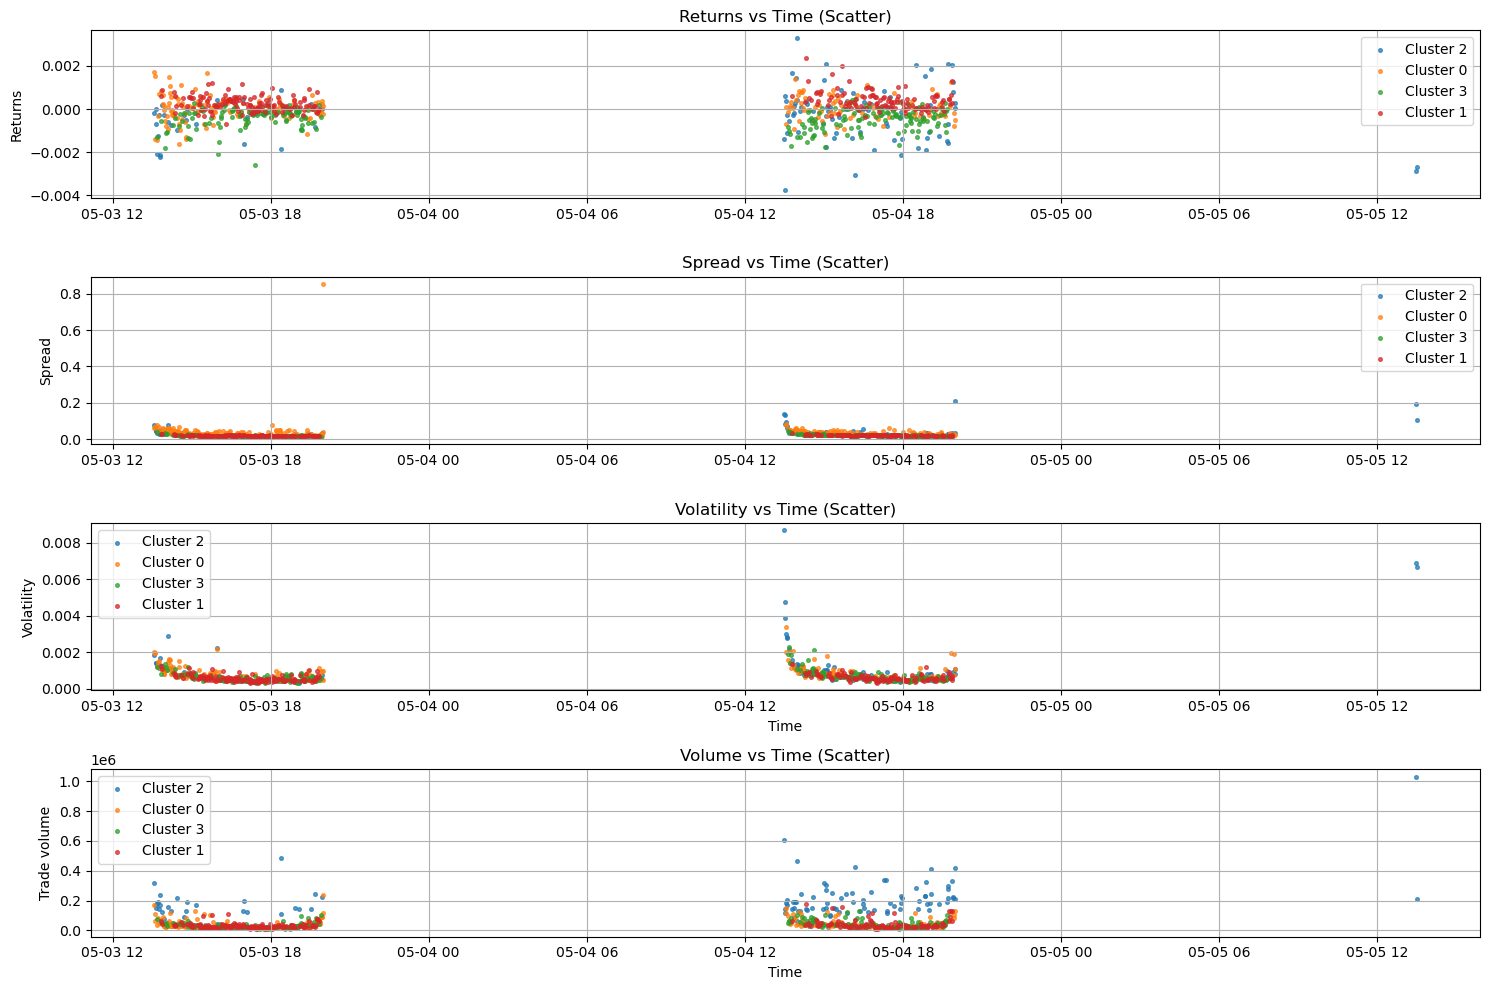

In [114]:
import matplotlib.pyplot as plt

# Extract data for plotting
plot_data = windowed_results.iloc[4]  # Using the first window for demonstration
cluster_assignments = plot_data["cluster_assignments"]
cluster_df = pd.DataFrame(cluster_assignments)








cluster_df = pd.merge(cluster_df, market_data, left_on="minute", right_on="minute")


# Scatter plot settings
plt.figure(figsize=(15, 10))

# Scatter plot: returns vs time
plt.subplot(4, 1, 1)
for cluster_id in cluster_df["cluster"].unique():
    cluster_data = cluster_df[cluster_df["cluster"] == cluster_id]
    plt.scatter(cluster_data["minute"], cluster_data["avg_return"], label=f"Cluster {cluster_id}", alpha=0.7, s=7)
plt.title("Returns vs Time (Scatter)")
plt.ylabel("Returns")
plt.legend()
plt.grid()

# Scatter plot: spread vs time
plt.subplot(4, 1, 2)
for cluster_id in cluster_df["cluster"].unique():
    cluster_data = cluster_df[cluster_df["cluster"] == cluster_id]
    plt.scatter(cluster_data["minute"], cluster_data["avg_spread"], label=f"Cluster {cluster_id}", alpha=0.7,s=7)
plt.title("Spread vs Time (Scatter)")
plt.ylabel("Spread")
plt.legend()
plt.grid()

# Scatter plot: volatility vs time
plt.subplot(4, 1, 3)
for cluster_id in cluster_df["cluster"].unique():
    cluster_data = cluster_df[cluster_df["cluster"] == cluster_id]
    plt.scatter(cluster_data["minute"], cluster_data["return_volatility"], label=f"Cluster {cluster_id}", alpha=0.7, s=7)
plt.title("Volatility vs Time (Scatter)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid()

# Scatter plot: volatility vs time
plt.subplot(4, 1, 4)
for cluster_id in cluster_df["cluster"].unique():
    cluster_data = cluster_df[cluster_df["cluster"] == cluster_id]
    plt.scatter(cluster_data["minute"], cluster_data["avg_trade_volume"], label=f"Cluster {cluster_id}", alpha=0.7, s=7)
plt.title("Volume vs Time (Scatter)")
plt.xlabel("Time")
plt.ylabel("Trade volume")
plt.legend()
plt.grid()

# Display the scatter plots
plt.tight_layout()
plt.show()



In [100]:
windowed_results.iloc[0]['average_market_data']

{'avg_price_volatility': 33.85497595917862,
 'avg_return_volatility': 0.0007682685366020834,
 'avg_return': -5.978997384691993e-05,
 'avg_trade_volume': 61344.90297228027,
 'avg_advancing_stocks': 0.4848520453180044,
 'avg_spread': 0.028995803645943542}

In [104]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def analyze_cluster_returns(df):
    """
    Analyze the distribution of returns across clusters
    """
    all_returns = []
    for _, row in df.iterrows():
        for cluster in row['cluster_characteristics']:
            all_returns.append(cluster['mean_return'])
    
    return {
        'mean': np.mean(all_returns),
        'std': np.std(all_returns),
        'percentiles': np.percentile(all_returns, [5, 25, 50, 75, 95])
    }

def calculate_cluster_signal(cluster_data, return_threshold=0.0001):
    """
    Calculate trading signal for a single cluster
    """
    return_signal = cluster_data['mean_return'] / cluster_data['std_return']
    volatility_factor = cluster_data['mean_volatility'] / cluster_data['std_return']
    
    # Normalize by cluster size
    confidence = (cluster_data['size'] / 100)  # Normalize size impact
    
    # Combined signal incorporating return, volatility, and size
    signal = return_signal * confidence / (1 + volatility_factor)
    
    if abs(signal) < return_threshold:
        return 'hold', abs(signal)
    return 'buy' if signal > 0 else 'sell', abs(signal)

def generate_trading_signals(df):
    """
    Generate trading signals based on cluster analysis
    """
    signals = []
    
    # First pass - analyze return distribution
    return_stats = analyze_cluster_returns(df)
    return_threshold = np.std([c['mean_return'] for c in df.iloc[0]['cluster_characteristics']])
    
    for idx, row in df.iterrows():
        row_signals = {
            'mean': {'signal': 'hold', 'confidence': 0},
            'median': {'signal': 'hold', 'confidence': 0},
            'hl_median': {'signal': 'hold', 'confidence': 0}
        }
        
        cluster_signals = []
        cluster_confidences = []
        
        # Generate signals for each cluster
        for cluster in row['cluster_characteristics']:
            signal, confidence = calculate_cluster_signal(cluster, return_threshold)
            cluster_signals.append(signal)
            cluster_confidences.append(confidence)
        
        if not cluster_signals:
            signals.append(row_signals)
            continue
            
        # Aggregate signals using different methods
        # 1. Mean-based signal
        buy_confidence = sum(conf for sig, conf in zip(cluster_signals, cluster_confidences) if sig == 'buy')
        sell_confidence = sum(conf for sig, conf in zip(cluster_signals, cluster_confidences) if sig == 'sell')
        
        if buy_confidence > sell_confidence and buy_confidence > return_threshold:
            row_signals['mean'] = {'signal': 'buy', 'confidence': buy_confidence}
        elif sell_confidence > buy_confidence and sell_confidence > return_threshold:
            row_signals['mean'] = {'signal': 'sell', 'confidence': sell_confidence}
            
        # 2. Median-based signal
        median_signal = pd.Series(cluster_signals).mode().iloc[0]
        median_conf = np.median(cluster_confidences)
        if median_conf > return_threshold:
            row_signals['median'] = {'signal': median_signal, 'confidence': median_conf}
            
        # 3. HL Pseudo-median signal
        if len(cluster_signals) > 1:
            hl_signals = []
            hl_confidences = []
            
            for i in range(len(cluster_signals)):
                for j in range(i+1, len(cluster_signals)):
                    if cluster_signals[i] == cluster_signals[j]:
                        hl_signals.append(cluster_signals[i])
                        hl_confidences.append((cluster_confidences[i] + cluster_confidences[j]) / 2)
            
            if hl_signals:
                most_common = pd.Series(hl_signals).mode().iloc[0]
                avg_conf = np.mean(hl_confidences)
                if avg_conf > return_threshold:
                    row_signals['hl_median'] = {'signal': most_common, 'confidence': avg_conf}
        
        signals.append(row_signals)
    
    return pd.DataFrame(signals)

def calculate_returns(df, signals):
    """
    Calculate strategy returns with position sizing
    """
    returns = pd.DataFrame(index=df.index)
    
    for strategy in ['mean', 'median', 'hl_median']:
        strategy_returns = []
        
        for idx, (_, row) in enumerate(df.iterrows()):
            signal = signals.iloc[idx][strategy]['signal']
            confidence = signals.iloc[idx][strategy]['confidence']
            
            # Calculate weighted return for current period
            total_size = sum(c['size'] for c in row['cluster_characteristics'])
            period_return = sum(c['mean_return'] * c['size'] for c in row['cluster_characteristics']) / total_size
            
            # Apply position sizing based on confidence
            position_size = min(confidence * 2, 1.0)  # Cap position size at 100%
            
            if signal == 'buy':
                strategy_returns.append(period_return * position_size)
            elif signal == 'sell':
                strategy_returns.append(-period_return * position_size)
            else:
                strategy_returns.append(0)
        
        returns[f'{strategy}_returns'] = strategy_returns
        returns[f'{strategy}_cumulative'] = (1 + pd.Series(strategy_returns)).cumprod()
    
    return returns

def calculate_performance_metrics(returns):
    """
    Calculate comprehensive performance metrics
    """
    performance = {}
    
    for strategy in ['mean', 'median', 'hl_median']:
        strategy_returns = returns[f'{strategy}_returns']
        cumulative_returns = returns[f'{strategy}_cumulative']
        
        # Calculate drawdown
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        
        # Daily returns to annualized metrics
        annual_factor = np.sqrt(252)  # Assuming daily data

        
        performance[strategy] = {
            'total_return': float(cumulative_returns.iloc[-1] - 1),
            'annualized_return': float(np.mean(strategy_returns) * 252),
            'volatility': float(np.std(strategy_returns) * annual_factor),
            'sharpe_ratio': float(np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-10) * annual_factor),
            'max_drawdown': float(drawdown.min()),
            'win_rate': float((strategy_returns > 0).mean()),
            'avg_win': float(strategy_returns[strategy_returns > 0].mean()),
            'avg_loss': float(strategy_returns[strategy_returns < 0].mean()),
            'profit_factor': float(abs(strategy_returns[strategy_returns > 0].sum() / 
                                     (strategy_returns[strategy_returns < 0].sum() + 1e-10))),
            'num_trades': int((strategy_returns != 0).sum())
        }
    
    return performance

def implement_market_state_strategy(df):
    """
    Implement the complete market state strategy
    """
    # Generate signals
    signals = generate_trading_signals(df)
    
    # Calculate returns
    returns = calculate_returns(df, signals)
    
    # Calculate performance metrics
    performance = calculate_performance_metrics(returns)
    
    return signals, returns, performance

In [105]:
# Implement strategy
signals, returns, performance = implement_market_state_strategy(windowed_results)

# Print detailed performance
for strategy, metrics in performance.items():
    print(f"\n{strategy.upper()} Strategy Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Check signal distribution
print("\nSignal Distribution:")
for col in ['mean', 'median', 'hl_median']:
    print(f"\n{col.upper()}:")
    print(signals[col].apply(lambda x: x['signal']).value_counts())


MEAN Strategy Performance:
total_return: 0.0026
annualized_return: 0.0159
volatility: 0.0002
sharpe_ratio: 70.8015
max_drawdown: 0.0000
win_rate: 1.0000
avg_win: 0.0001
avg_loss: nan
profit_factor: 25870614.1764
num_trades: 41.0000

MEDIAN Strategy Performance:
total_return: -0.0019
annualized_return: -0.0114
volatility: 0.0006
sharpe_ratio: -19.1590
max_drawdown: -0.0018
win_rate: 0.0976
avg_win: 0.0001
avg_loss: -0.0001
profit_factor: 0.1104
num_trades: 41.0000

HL_MEDIAN Strategy Performance:
total_return: -0.0019
annualized_return: -0.0118
volatility: 0.0005
sharpe_ratio: -22.2237
max_drawdown: -0.0019
win_rate: 0.0976
avg_win: 0.0000
avg_loss: -0.0001
profit_factor: 0.0855
num_trades: 41.0000

Signal Distribution:

MEAN:
mean
sell    41
Name: count, dtype: int64

MEDIAN:
median
buy     37
sell     4
Name: count, dtype: int64

HL_MEDIAN:
hl_median
buy     37
sell     4
Name: count, dtype: int64


In [52]:
(1+0.00025626072191593064)**390 -1 

0.10509231909340011

In [92]:
(1+0.003734)**20 - 1

0.07738942783624947